# Working with index

## Content
* [Index types](#Index-types)
* [How to create an index](#How-to-create-an-index)
    * [from SEGY files](#from-SEGY-files)
    * [from SPS files](#from-SPS-files)
* [Conversion between types](#Conversion-between-types)
* [Merge](#Merge)

## Index types

There are 5 basic types of indices:
* ```TraceIndex``` enumerates individual traces
* ```FieldIndex``` enumerates field records
* ```SegyFilesIndex``` enumerates SEGY files
* ```BinsIndex``` enumerated bins of regular grid
* ```KNNIndex``` enumerated groups of k nearest traces

and ```CustomIndex``` that enables enumeration on a basis of any ```segyio.TraceField``` attribute, e.g. ```INLINE_3D``` or ```ShotPoint```.

There is an easy convertion between index types. Let ```index``` be an instance of some intex type, then  ```FieldIndex(index)``` will be an instance of type ```FieldIndex```, while ```TraceIndex(index)``` will be an instance of type ```TraceIndex``` etc.

Index can be created from a single SEGY file, from multiple SEGY files and from SPS files. Index can be merged with another one index. Below we illustrate these options. 

## How to create an index

### from SEGY files

We start with a single SEGY file and create a ```TraceIndex```. It requieres path to the file and name that we will assosiate with traces:   

In [1]:
import sys
import pandas as pd
import numpy as np

sys.path.append('..')
from geolog.src import (FieldIndex, TraceIndex, SegyFilesIndex, BinsIndex,
                        CustomIndex, KNNIndex, SeismicBatch)
from geolog.batchflow import Dataset

path_raw = '/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy'
index_trace = TraceIndex(name='raw', path=path_raw)

```head()``` shows 5 first traces (similar to pandas):

In [2]:
index_trace.head()

,TraceNumber,FieldRecord,TRACE_SEQUENCE_FILE,file_id
,,,raw,raw
0,1656,111906,1,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
1,1657,111906,2,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
2,1655,111906,3,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
3,1658,111906,4,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
4,1654,111906,5,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy


Note the index contains columns ```TraceNumber``` and ```FieldRecord``` that uniquely define seismic traces. ```TRACE_SEQUENCE_FILE``` gives a trace location within the file. To include more columns , use ```extra_headers``` argument (or set ```extra_headers='all'``` to include all available headers):

In [3]:
index_trace = TraceIndex(name='raw', path=path_raw, extra_headers=['ShotPoint', 'offset'])
index_trace.head()

,offset,TraceNumber,ShotPoint,FieldRecord,TRACE_SEQUENCE_FILE,file_id
,,,,,raw,raw
0,35,1656,42000,111906,1,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
1,36,1657,42000,111906,2,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
2,78,1655,42000,111906,3,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
3,79,1658,42000,111906,4,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
4,127,1654,42000,111906,5,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy


In the next example we will create an index of field records from a set of SEGY files:

In [4]:
index_ffid = FieldIndex(name='raw', path='/notebooks/egor/2D_Valyton/prof_37/segy/*.sgy')         
index_ffid.head()

,TraceNumber,TRACE_SEQUENCE_FILE,file_id
,,raw,raw
FieldRecord,,,
354,1,1,/notebooks/egor/2D_Valyton/prof_37/segy/000003...
354,2,2,/notebooks/egor/2D_Valyton/prof_37/segy/000003...
354,1,3,/notebooks/egor/2D_Valyton/prof_37/segy/000003...
354,2,4,/notebooks/egor/2D_Valyton/prof_37/segy/000003...
354,3,5,/notebooks/egor/2D_Valyton/prof_37/segy/000003...


Note that SEGY files contain auxiliary traces and we obtain duplicated (FieldRecord, TraceNumber) pairs in the index. This can be checked with ```duplicated``` method:

In [5]:
np.any(index_ffid.duplicated())

True

Method ```drop_duplicated``` helps to remove auxiliary traces:

In [6]:
index_ffid = index_ffid.drop_duplicates(keep='last')
index_ffid.head()

,TraceNumber,TRACE_SEQUENCE_FILE,file_id
,,raw,raw
FieldRecord,,,
354,1,3,/notebooks/egor/2D_Valyton/prof_37/segy/000003...
354,2,4,/notebooks/egor/2D_Valyton/prof_37/segy/000003...
354,3,5,/notebooks/egor/2D_Valyton/prof_37/segy/000003...
354,4,6,/notebooks/egor/2D_Valyton/prof_37/segy/000003...
354,5,7,/notebooks/egor/2D_Valyton/prof_37/segy/000003...


If we assume iteration over files, we create a ```SegyFilesIndex``` in a similar way:

In [7]:
index_files = SegyFilesIndex(name='raw', path='/notebooks/egor/2D_Valyton/prof_37/segy/*.sgy')          
index_files.head()

,TraceNumber,FieldRecord,TRACE_SEQUENCE_FILE
,,,raw
"(file_id, raw)",,,
/notebooks/egor/2D_Valyton/prof_37/segy/00000354_f1.r354.sgy,1,354,1
/notebooks/egor/2D_Valyton/prof_37/segy/00000354_f1.r354.sgy,2,354,2
/notebooks/egor/2D_Valyton/prof_37/segy/00000354_f1.r354.sgy,1,354,3
/notebooks/egor/2D_Valyton/prof_37/segy/00000354_f1.r354.sgy,2,354,4
/notebooks/egor/2D_Valyton/prof_37/segy/00000354_f1.r354.sgy,3,354,5


To make things more flexible, there is a ```CustomIndex``` that allows iteration by any ```segyio.TraceField``` attribute, e.g. ```INLINE_3D```, ```ShotPoint```, ```CDP``` etc. For example, let's create an index of shot points:

In [8]:
index_shot = CustomIndex(name='raw', index_name='ShotPoint', path=path_raw)
index_shot.head()

,TraceNumber,FieldRecord,TRACE_SEQUENCE_FILE,file_id
,,,raw,raw
ShotPoint,,,,
42000,1656,111906,1,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
42000,1657,111906,2,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
42000,1655,111906,3,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
42000,1658,111906,4,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
42000,1654,111906,5,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy


Finally, there is a```KNNIndex``` that enumerates groups of k nearest located traces based on its ```CDP_X``` and ```CDP_Y``` attributes: 

In [9]:
index_knn = KNNIndex(name='raw', n_neighbors=3, path=path_raw)
index_knn.head(9)

,FieldRecord,CDP_X,TraceNumber,CDP_Y,TRACE_SEQUENCE_FILE,file_id
,,,,,raw,raw
KNN,,,,,,
0,111906,499279,1656,6639805,1,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
0,111906,499304,1657,6639805,2,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
0,111906,499254,1655,6639805,3,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
1,111906,499304,1657,6639805,2,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
1,111906,499279,1656,6639805,1,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
1,111906,499329,1658,6639805,4,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
2,111906,499254,1655,6639805,3,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
2,111906,499279,1656,6639805,1,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy


### from SPS files

```TraceIndex``` and ```FieldIndex``` can be alternatively constructed from SPS files. As a by-product, it will include offsets, azimuth and a number of other metadata: 

In [10]:
dfx = pd.read_csv('/notebooks/egor/2D_Valyton/sps/ALL_VALUNT0910_X37.csv')
dfr = pd.read_csv('/notebooks/egor/2D_Valyton/sps/ALL_VALUNT0910_R_utm.csv')
dfs = pd.read_csv('/notebooks/egor/2D_Valyton/sps/ALL_VALUNT0910_S_utm.csv')

index_sps = FieldIndex(dfx=dfx, dfr=dfr, dfs=dfs)
index_sps.head()

,sline,sid,rline,rid,TraceNumber,point_index,sht_depth,uphole,SourceX,SourceY,z_s,x_r,y_r,z_r,CDP_X,CDP_Y,azimuth,offset
,,,,,,,,,,,,,,,,,,
FieldRecord,,,,,,,,,,,,,,,,,,
354,S37,3591,R37,290,72,1,18.0,14.0,338886.78,7033413.0,71.5,338725.94,7031696.5,87.8,338806.360,7032554.75,-1.664226,862.009535
354,S37,3591,R37,367,149,1,18.0,14.0,338886.78,7033413.0,71.5,338905.56,7033612.0,69.9,338896.170,7033512.50,1.476703,99.942094
354,S37,3591,R37,368,150,1,18.0,14.0,338886.78,7033413.0,71.5,338907.88,7033637.0,70.2,338897.330,7033525.00,1.476877,112.495789
354,S37,3591,R37,419,201,1,18.0,14.0,338886.78,7033413.0,71.5,339027.12,7034906.0,67.8,338956.950,7034159.50,1.477073,749.790690
354,S37,3591,R37,485,267,1,18.0,14.0,338886.78,7033413.0,71.5,339181.25,7036547.5,64.8,339034.015,7034980.25,1.477126,1574.150789


To create a ```Binsindex``` one should specify ```bin_size```. If grid position is not provided it will be optimized during index construction: 

In [11]:
dfx = pd.read_csv('/notebooks/egor/Xfield/Xfield_X.csv')
dfr = pd.read_csv('/notebooks/egor/Xfield/Xfield_R.csv')
dfs = pd.read_csv('/notebooks/egor/Xfield/Xfield_S.csv')

bin_size = 1000

index_bin = BinsIndex(dfr=dfr, dfs=dfs, dfx=dfx, bin_size=(bin_size, bin_size), max_iters=10)
index_bin.head()

,FieldRecord,sline,sid,rline,rid,TraceNumber,SourceX,SourceY,z_s,x_r,y_r,z_r,CDP_X,CDP_Y,azimuth,offset
,,,,,,,,,,,,,,,,
bin_id,,,,,,,,,,,,,,,,
1/16,327541Z,S2305,5598,R5601,2319,439,503985.5,6630966.5,37.9,504710.4,6631092.0,37.9,504347.95,6631029.25,0.171428,367.841766
1/16,327521Z,S2305,5597,R5601,2305,425,503985.5,6630917.0,38.1,504010.7,6631092.0,38.1,503998.10,6631004.50,1.427779,88.402545
1/16,327541Z,S2305,5598,R5601,2305,425,503985.5,6630966.5,37.9,504010.7,6631092.0,38.1,503998.10,6631029.25,1.372635,64.002519
1/16,327561Z,S2305,5599,R5601,2305,425,503985.5,6631016.5,38.0,504010.7,6631092.0,38.1,503998.10,6631054.25,1.248648,39.797267
1/16,327581Z,S2305,5600,R5601,2305,425,503985.5,6631066.5,38.0,504010.7,6631092.0,38.1,503998.10,6631079.25,0.791315,17.925471


The heatmap shows a distribution of traces within bins:

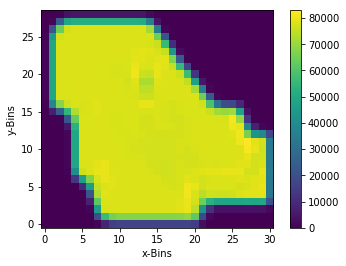

In [12]:
index_bin.show_heatmap()

## Conversion between types

Index can be easily converted to other index type. For example, ```FieldIndex``` to ```TraceIndex```:

In [13]:
TraceIndex(index_ffid).head()

,FieldRecord,TraceNumber,TRACE_SEQUENCE_FILE,file_id
,,,raw,raw
0,354,1,3,/notebooks/egor/2D_Valyton/prof_37/segy/000003...
1,354,2,4,/notebooks/egor/2D_Valyton/prof_37/segy/000003...
2,354,3,5,/notebooks/egor/2D_Valyton/prof_37/segy/000003...
3,354,4,6,/notebooks/egor/2D_Valyton/prof_37/segy/000003...
4,354,5,7,/notebooks/egor/2D_Valyton/prof_37/segy/000003...


or vise-versa:

In [14]:
FieldIndex(index_trace).head()

,offset,TraceNumber,ShotPoint,TRACE_SEQUENCE_FILE,file_id
,,,,raw,raw
FieldRecord,,,,,
111906,35,1656,42000,1,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
111906,36,1657,42000,2,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
111906,78,1655,42000,3,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
111906,79,1658,42000,4,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
111906,127,1654,42000,5,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy


or ```BinsIndex``` to ```FieldIndex```:

In [15]:
FieldIndex(index_bin).head()

,bin_id,sline,sid,rline,rid,TraceNumber,SourceX,SourceY,z_s,x_r,y_r,z_r,CDP_X,CDP_Y,azimuth,offset
,,,,,,,,,,,,,,,,
FieldRecord,,,,,,,,,,,,,,,,
10001Z,17/20,S2417,5284,R5289,2362,746,509583.9,6615273.0,38.1,506859.4,6615497.5,39.9,508221.65,6615385.25,3.059378,1366.866901
10001Z,17/22,S2417,5284,R5277,2427,587,509583.9,6615273.0,38.1,510108.2,6614898.0,36.9,509846.05,6615085.50,-0.620881,322.302455
10001Z,18/21,S2417,5284,R5247,2410,50,509583.9,6615273.0,38.1,509258.8,6613398.5,35.4,509421.35,6614335.75,-1.742521,951.241328
10001Z,17/22,S2417,5284,R5289,2424,808,509583.9,6615273.0,38.1,509958.3,6615497.5,37.3,509771.10,6615385.25,0.540145,218.274832
10001Z,17/23,S2417,5284,R5277,2455,615,509583.9,6615273.0,38.1,511507.9,6614898.0,34.8,510545.90,6615085.50,-0.192493,980.102163


or custom shot index to ```FieldIndex```:

In [16]:
FieldIndex(index_shot).head()

,ShotPoint,TraceNumber,TRACE_SEQUENCE_FILE,file_id
,,,raw,raw
FieldRecord,,,,
111906,42000,1656,1,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
111906,42000,1657,2,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
111906,42000,1655,3,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
111906,42000,1658,4,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
111906,42000,1654,5,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy


or ```KNNIndex``` to ```FieldIndex```:

In [17]:
FieldIndex(index_knn).head(9)

,KNN,CDP_X,TraceNumber,CDP_Y,TRACE_SEQUENCE_FILE,file_id
,,,,,raw,raw
FieldRecord,,,,,,
111906,0,499279,1656,6639805,1,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
111906,0,499304,1657,6639805,2,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
111906,0,499254,1655,6639805,3,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
111906,1,499304,1657,6639805,2,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
111906,1,499279,1656,6639805,1,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
111906,1,499329,1658,6639805,4,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
111906,2,499254,1655,6639805,3,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
111906,2,499279,1656,6639805,1,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy


Note that the index obtained contains 3 times duplicated traces. To remove them use ```drop_duplicates```:

In [18]:
FieldIndex(index_knn).drop_duplicates().head(9)

,KNN,CDP_X,TraceNumber,CDP_Y,TRACE_SEQUENCE_FILE,file_id
,,,,,raw,raw
FieldRecord,,,,,,
111906,0,499279,1656,6639805,1,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
111906,0,499304,1657,6639805,2,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
111906,0,499254,1655,6639805,3,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
111906,1,499329,1658,6639805,4,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
111906,2,499229,1654,6639805,5,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
111906,3,499354,1659,6639805,6,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
111906,4,499204,1653,6639805,7,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy
111906,5,499379,1660,6639805,8,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy


## Merge

Two index instances can be merged on common headers. For example, ```index_ffid``` does not contain offsets. However, we can merge it with ```index_sps``` that includes offsets:

In [19]:
index_ffid = index_ffid.merge(index_sps)
index_ffid.head()

,TraceNumber,TRACE_SEQUENCE_FILE,file_id,sline,sid,rline,rid,point_index,sht_depth,uphole,SourceX,SourceY,z_s,x_r,y_r,z_r,CDP_X,CDP_Y,azimuth,offset
,,raw,raw,,,,,,,,,,,,,,,,,
FieldRecord,,,,,,,,,,,,,,,,,,,,
354,1,3,/notebooks/egor/2D_Valyton/prof_37/segy/000003...,S37,3591,R37,219,1,18.0,14.0,338886.78,7033413.0,71.5,338560.00,7029929.5,76.0,338723.39,7031671.25,-1.664331,1749.396855
354,2,4,/notebooks/egor/2D_Valyton/prof_37/segy/000003...,S37,3591,R37,220,1,18.0,14.0,338886.78,7033413.0,71.5,338562.40,7029954.5,76.1,338724.59,7031683.75,-1.664315,1736.839416
354,3,5,/notebooks/egor/2D_Valyton/prof_37/segy/000003...,S37,3591,R37,221,1,18.0,14.0,338886.78,7033413.0,71.5,338564.70,7029979.5,76.2,338725.74,7031696.25,-1.664328,1724.286648
354,4,6,/notebooks/egor/2D_Valyton/prof_37/segy/000003...,S37,3591,R37,222,1,18.0,14.0,338886.78,7033413.0,71.5,338567.00,7030004.5,76.8,338726.89,7031708.75,-1.664341,1711.733880
354,5,7,/notebooks/egor/2D_Valyton/prof_37/segy/000003...,S37,3591,R37,223,1,18.0,14.0,338886.78,7033413.0,71.5,338569.38,7030029.0,77.4,338728.08,7031721.00,-1.664317,1699.426283


Enjoy!